# Bayesian Machine Scientist

## Tutorial: Recovering the exponential learning curve model

In this tutorial, we'll learn how to use Bayesian Machine Scientist (BMS) as a theorist to recover the exponential learning curve model.

### Installing AutoRA

We begin with installing AutoRA via the pip package manager, and then import the relevant modules:

In [1]:
!pip install autora

import numpy as np
from autora.variable import DV, IV, ValueType, VariableCollection
from autora.skl.bms import BMSRegressor


[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


### Generating Data

Next, we generate a relevant data set. We'll start by setting the relevant meta-parameter, which is the level of noise to add to the ground-truth model.

In [2]:
# general meta parameters
added_noise = 0.01

Next, we set the specific parameters for the exponential learning curve model

In [3]:
# exponential learning curve parameters
exp_learning_resolution = 100
exp_learning_minimum_trial = 1
exp_learning_maximum_trial = exp_learning_resolution
exp_learning_minimum_initial_value = 0
exp_learning_maximum_initial_value = 0.5
exp_learning_lr = 0.03
exp_learning_p_asymptotic = 1.0

We then set up the ground-truth model. To do so, we first define our metadata

In [4]:
def exp_learning_metadata():
    p_initial = IV(
        name="P_asymptotic",
        allowed_values=np.linspace(exp_learning_minimum_initial_value,
                                   exp_learning_maximum_initial_value,
                                   exp_learning_resolution),
        value_range=(exp_learning_minimum_initial_value,
                     exp_learning_maximum_initial_value),
        units="performance",
        variable_label="Asymptotic Performance",
        type=ValueType.REAL
    )

    trial = IV(
        name="trial",
        allowed_values=np.linspace(exp_learning_minimum_trial,
                                   exp_learning_maximum_trial,
                                   exp_learning_resolution),
        value_range=(exp_learning_minimum_trial,
                     exp_learning_maximum_trial),
        units="trials",
        variable_label="Trials",
        type=ValueType.REAL
    )

    performance = DV(
        name="performance",
        value_range=(0, exp_learning_p_asymptotic),
        units="performance",
        variable_label="Performance",
        type=ValueType.REAL
    )

    metadata = VariableCollection(
        independent_variables=[p_initial, trial],
        dependent_variables=[performance],
    )

    return metadata

Then we define our synthetic experiment

In [5]:
def exp_learning_experiment(X: np.ndarray,
                             p_asymptotic: float = exp_learning_p_asymptotic,
                             lr: float = exp_learning_lr,
                             std = added_noise):
    Y = np.zeros((X.shape[0],1))

    for idx, x in enumerate(X):
        p_initial = x[0]
        trial = x[1]
        y = p_asymptotic - (p_asymptotic - p_initial) * np.exp(- lr * trial) + np.random.normal(0, std)
        Y[idx] = y

    return Y

Finally, we define how to generate synthetic data

In [6]:
def exp_learning_data(metadata):

    p_initial_values = metadata.independent_variables[0].allowed_values
    trial_values = metadata.independent_variables[1].allowed_values

    X = np.array(np.meshgrid(p_initial_values, trial_values)).T.reshape(-1,2)
    y = exp_learning_experiment(X, std=0)

    return X, y

With these functions defined, we can now create a data set from a noisy ground-truth model

In [7]:
X, y = exp_learning_data(exp_learning_metadata())

Now let us define the search space, that is, the space of operations to consider when searching over the space of computation graphs. In order to use BMS as a theorist, we need to assign priors to its set of possible operators. These priors can be whatever we like, but in this case we'll use those established by Guimerà et al. 2020

In [8]:
primitives = {
    "Nopi_/": 5.912205942815285,
            "Nopi_cosh": 8.12720511103694,
            "Nopi_-": 3.350846072163632,
            "Nopi_sin": 5.965917796154835,
            "Nopi_tan": 8.127427922862411,
            "Nopi_tanh": 7.799259068142255,
            "Nopi_**": 6.4734429542245495,
            "Nopi_pow2": 3.3017352779079734,
            "Nopi_pow3": 5.9907496760026175,
            "Nopi_exp": 4.768665265735502,
            "Nopi_log": 4.745957377206544,
            "Nopi_sqrt": 4.760686909134266,
            "Nopi_cos": 5.452564657261127,
            "Nopi_sinh": 7.955723540761046,
            "Nopi_abs": 6.333544134938385,
            "Nopi_+": 5.808163661224514,
            "Nopi_*": 5.002213595420244,
            "Nopi_fac": 10.0,
            "Nopi2_*": 1.0,
            "Nopi_sig": 1.0,
            "Nopi_relu": 1.0,
}

The other meta-parameters we need to set for BMS include a list of temperatures for its tree search, as well as the number of epochs we want BMS to run. We'll do that next in creating our BMSRegressor

In [9]:
temperatures = [1.0] + [1.04**k for k in range(1, 20)]

bms = BMSRegressor(
    epochs=1000,
    prior_par=primitives,
    ts=temperatures,
)

With regressor created and all its meta-parameters assigned, we can now fit the regressor to our synthetic data set. That is, we can use the BMSRegressor to recover an equation that it thinks best maps X to y.

In [10]:
bms.fit(X,y)

/Users/benwandrew/Library/Caches/pypoetry/virtualenvs/autora--WSX6yBF-py3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:autora.skl.bms:BMS fitting started
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/benwandrew/Developer/autora/autora/theorist/bms/mcmc.py:1253: RuntimeWarning: overflow encountered in exp
  float(nif) * omegai * sf * np.exp(-dEB / self.BT - dEP / self.PT)
/Users/benwandrew/Developer/autora/autora/theorist/bms/mcmc.py:1197: RuntimeWarning: overflow encountered in exp
  paccept = np.exp(-dEB / self.BT - dEP / self.PT)
  0%|          | 1/1000 [00:00<05:02,  3.31it/s]/Users/benwandrew/Library/Caches/pypoetry/virtualenvs/autora--WSX6yBF-py3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in square
  result = getattr(

BMSRegressor(epochs=1000)

Now that we have both our ground-truth and the BMS candidate models, we can plot them and compare results. We define how to create our plot

In [11]:
def plot_exp_learning(model = None):
    plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    import matplotlib.pyplot as plt
    metadata = exp_learning_metadata()

    P_0_list = [0, 0.25, 0.5]
    trial = metadata.independent_variables[1].allowed_values

    for P_0_index, P_0 in enumerate(P_0_list):
        X = np.zeros((len(trial), 2))
        X[:, 0] = P_0
        X[:, 1] = trial

        y = exp_learning_experiment(X, std=0)
        plt.plot(trial, y, label=f"$P_0 = {P_0}$ (Original)", color = plot_colors[P_0_index])
        if model is not None:
            y = model.predict(X)
            plt.plot(trial, y, label=f"$P_0 = {P_0}$ (Recovered)", linestyle="--", color = plot_colors[P_0_index])

    x_limit = [0, metadata.independent_variables[1].value_range[1]]
    y_limit = [0, 1]
    x_label = "Trial $t$"
    y_label = "Performance $P_n$"

    plt.xlim(x_limit)
    plt.ylim(y_limit)
    plt.xlabel(x_label, fontsize="large")
    plt.ylabel(y_label, fontsize="large")
    plt.legend(loc=4, fontsize="medium")
    plt.title("Exponential Learning", fontsize="x-large")
    plt.show()

And then we pass in our new BMS candidate model to get our visual comparison

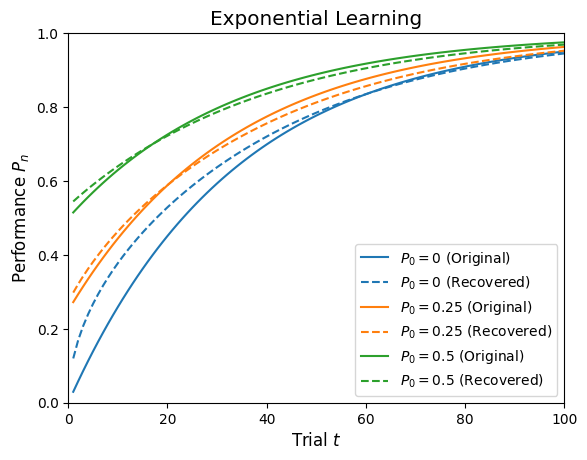

In [12]:
plot_exp_learning(bms)
